In [1]:
import pynedm


# Authentication
po = pynedm.ProcessObject("http://10.155.59.88:5984", "un", """pw""", "nedm%2Fmeasurements")
acct = po.acct

# Grab the correct database
db = acct["nedm%2Fmeasurements"]

# Get a list of measurements
# The query here is important, measure_name can be the initial stem of a set of
# measurements.  (Note: regular expressions are *not* supported by couch) This
# is used to define the endkey and startkey in the following query.
measure_name = "Mike Triggering"
query_dic = dict(descending=True,
                 endkey=[measure_name, 2015, 9, 16], # Gets on a particular day (16 June 2016)
                 startkey=[measure_name + "\ufff0", 2015, 9, 16, {}],
                 #endkey=[measure_name], # Gets *all* measurements with this stem
                 #startkey=[measure_name + "\ufff0", {}],
                 include_docs=True,
                 reduce=False
                 )

res = db.design('measurements').view('measurements').get(
                    params=query_dic)


# Get ids of documents
all_docs = [d["doc"] for d in res.json()["rows"]]
print("Found {} measurements\n".format(len(all_docs)))


Found 1 measurements



In [2]:
import struct
import json
import numpy
def interpret_file(file_name, doc_id=None):
    """
    File structure is:
       bytes 0..3: length of json header N (excluding header word)
       bytes 4..4+N: json header (ASCII data)
       bytes 4+N+1..EOF: binary data of channels
    The binary data format depends on what's in the json header:
      header["channel_list"] ---> ordered list of channels
      header["byte_depth"]    ---> size of binary word
      header["bit_shift"]    ---> amount to shift right
    Every channel is listed one after another for each time point (fully
    interlaced)
    """
    ll = lambda : open(file_name)
    if doc_id is not None:
        ll = lambda : po.open_file(doc_id, file_name)

    with ll() as o:
        header_length = struct.unpack("<L", o.read(4))[0]
        o.seek(4)
        hdr = json.loads(o.read(header_length))
        try:
            bit_depth = hdr["bit_depth"]
        except:
            bit_depth = hdr["byte_depth"]
        bit_shift = hdr["bit_shift"]
        dt = None
        if bit_depth == 2: dt = numpy.int16
        elif bit_depth ==4: dt = numpy.int32
        elif bit_depth == 8: dt = numpy.float64
        else: raise Exception("unknown bit_depth")

        def channel_dict(dat):
            x = dat
            if bit_shift != 0:
                x = numpy.right_shift(dat, bit_shift)

            cl = hdr["channel_list"]
            total_ch = len(cl)

            # Now create a dictionary of the channels
            return dict([(cl[i],x[i::total_ch]) for i in range(len(cl))])

        # Reads from position 4 + header_length
        o.seek(4+header_length)

        # We should always read by a factor of this chunk_size
        chunk_size = bit_depth * len(hdr["channel_list"])

        # We can iterate over everything...
        print("Iterating")
        return o.iterate(100*1024*chunk_size), channel_dict, dt

In [4]:
y, cd, dt = interpret_file(all_docs[0]["external_docs"].keys()[0], all_docs[0]["_id"])
adic = None
for x in y:
    nd = cd(numpy.fromstring(x, dtype=dt))
    if not adic:
        adic = nd
    else:
        for g in adic:
            adic[g] = numpy.append(adic[g], nd[g])

Iterating


In [5]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


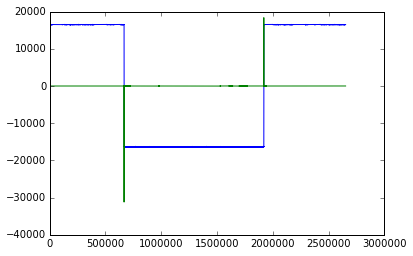

In [6]:
threshold = 1000

h = adic[10]
trig_find = h[1:] - h[:-1]

trig_pts = numpy.argwhere(numpy.abs(trig_find) > threshold)

plt.plot(h)
plt.plot(trig_find)



In [15]:
# Now deal with the triggers
cur_trig = -1
all_triggers = []
for x in trig_pts:
    if x[0] == cur_trig + 1:
        cur_trig = x[0]
        continue
    else:
        cur_trig = x[0]
        all_triggers.append(x[0])

# This should alternate between pos and negative
trig_find[all_triggers]

array([-31195,  18370], dtype=int16)